In [1]:
import os
import logging
import tempfile
from pathlib import Path

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio.plot
from rasterio.enums import Resampling

here = Path.cwd() / "data"

# raster_methods.py -- old
from raster_methods import convert_crs, raster_mask, resample_to_destination
# MemoryRaster -- new
from memoryraster import MemoryRaster

# Read shapefile data
city_polygons = gpd.read_file(
    here / "vnm_adm_gov_20201027" / "vnm_admbnda_adm2_gov_20201027.shp"
)
print("  Number of city polygons =", len(city_polygons))
print("Vector co-ordinate system =", city_polygons.crs.srs)

  Number of city polygons = 708
Vector co-ordinate system = EPSG:4326


In [2]:
# Ensure that CRS of all rasters and vector are the same
aedes_raster_file = convert_crs(here / "aegypti.tif", city_polygons.crs.srs)
population_raster_file = convert_crs(
    here / "vnm_ppp_2020_UNadj_constrained.tif", city_polygons.crs.srs
)
aedes_masked, aedes_masked_transform = raster_mask(aedes_raster_file, city_polygons.geometry)
population_masked_high, population_masked_transform = raster_mask(population_raster_file, city_polygons.geometry)

Converting CRS for: /Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/data/aegypti.tif

raster_mask reading: /var/folders/2t/8v1v9w8s191f91fnq_f9t0600000gn/T/dartagg4hk6w7bg.tif
	crs: EPSG:4326
	bounds: BoundingBox(left=-180.0, bottom=-60.0, right=179.99985600000002, top=84.999942)
	transform: | 0.04, 0.00, 102.12|
| 0.00,-0.04, 23.42|
| 0.00, 0.00, 1.00|
	shape: (390, 378)

raster_mask reading: /Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/data/vnm_ppp_2020_UNadj_constrained.tif
	crs: EPSG:4326
	bounds: BoundingBox(left=102.145416273, bottom=8.562916834, right=109.46958291, top=23.392916775)
	transform: | 0.00, 0.00, 102.15|
| 0.00,-0.00, 23.39|
| 0.00, 0.00, 1.00|
	shape: (17796, 8789)


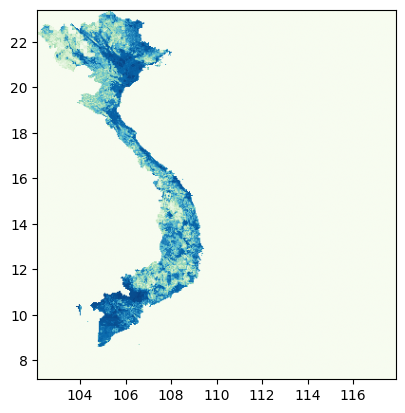

<Axes: >

In [3]:
aedes = MemoryRaster.read(here / "aegypti.tif", crs=city_polygons.crs.srs)
aedes_masked_m = aedes.mask(city_polygons)
aedes_masked_m.plot()

In [4]:
aedes_masked.min(), aedes_masked.max()

(np.float64(0.0), np.float64(0.9826877668036827))

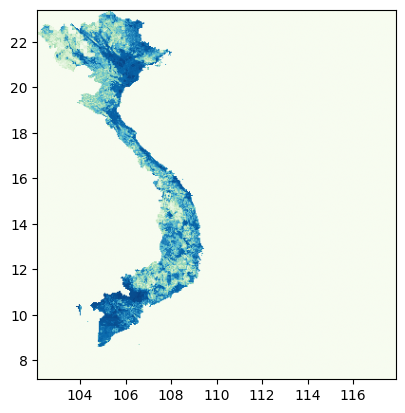

<Axes: >

In [5]:
rasterio.plot.show(aedes_masked, transform=aedes_masked_transform, cmap='GnBu')

In [6]:
population_high = MemoryRaster.read(here / "vnm_ppp_2020_UNadj_constrained.tif", crs=city_polygons.crs.srs)
population_masked_high_m = population_high.mask(city_polygons).astype(np.float32)
population_masked_high_m

<MemoryRaster (17796, 8789) CRS=EPSG:4326 min=0.0 max=28730.828125 NODATA=0 file=None
  transform=| 0.00, 0.00, 102.15|
| 0.00,-0.00, 23.39|
| 0.00, 0.00, 1.00|>

In [7]:
population_masked_high_m.sum()

np.float32(97411280.0)

In [8]:
population_masked_low = resample_to_destination(
    population_masked_high,
    population_masked_transform,
    aedes_masked,
    aedes_masked_transform,
    city_polygons.crs,
    resampling=Resampling.sum
)

Resampling using: 13


In [9]:
print(population_masked_low.shape, population_masked_low.min(), population_masked_low.max())

(390, 378) 0.0 1123080.1


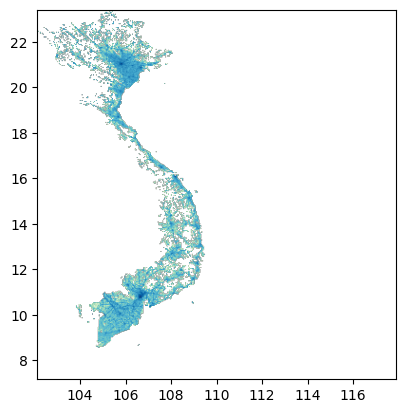

<Axes: >

In [10]:
rasterio.plot.show(population_masked_low, cmap='GnBu', norm='log', transform=aedes_masked_transform)

Resampling using: 13


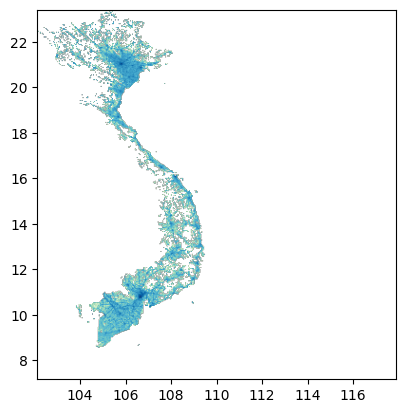

<Axes: >

In [11]:
population_masked_low_m = population_masked_high_m.resample(aedes_masked_m, Resampling.sum)
population_masked_low_m.plot(norm='log')

In [12]:
print("NEW SUMS (low/high):", population_masked_low_m.sum(), population_masked_high_m.sum())
print("OLD SUMS (low/high):", np.sum(population_masked_low), np.sum(population_masked_high))


NEW SUMS (low/high): 97411256.0 97411280.0
OLD SUMS (low/high): 97411256.0 97411280.0
